In [1]:
SEED = 0

import torch
torch.manual_seed(SEED)

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

In [2]:
def load(fn):
    with open(fn, 'r') as file_in:
        return file_in.read().split('\n')

In [3]:
def repl_t(text):
    text = text.replace('(t1)', '(x1)')
    text = text.replace('(t2)', '(x2)')
    text = text.replace('(t1,t2)', '(x1,x2)')
    return text

In [4]:
id_pairs = [[int(x) for x in l.split('\t')] for l in load('id_pairs_2.txt') if l != '']
sid2uids = {}

for s, u in id_pairs:
    if s not in sid2uids:
        sid2uids[s] = []
    sid2uids[s].append(u)

In [5]:
situations = [[int(l.split('\t')[0]), l.split('\t')[1]] for l in load('situations_2.txt') if l != '']

In [6]:
utterances = [[int(l.split('\t')[0]), l.split('\t')[1]] for l in load('utterances_2.txt') if l != '']

In [7]:
sit2id = {s[1]: s[0] for s in situations}

In [8]:
train_sit = [l.split('\t')[0] for l in load('training_set.txt')]
valid_sit = [l.split('\t')[0] for l in load('test_set.txt')]

In [9]:
train_sit_id = [sit2id[repl_t(s)] for s in train_sit if s != '']
valid_sit_id = [sit2id[repl_t(s)] for s in valid_sit if s != '']

In [10]:
import torch.nn.functional as F
import torch

class Vocab():
    def __init__(self):
        self.vocab = {}
        self.invert = {}
        self.len = 0
    
    def update(self, text, verbose=False):
        for char in text:
            if char not in self.vocab:
                self.vocab[char] = self.len
                self.invert[self.len] = char
                self.len += 1
                if verbose:
                    print('vocab size:', self.len, char)
    
    def tokenize(self, text):
        return torch.tensor([self.vocab[c] for c in text])
    
    def tokenize_oh(self, text):
        return F.one_hot(self.tokenize(text), num_classes=len(self))
    
    def decode(self, ids):
        return [self.invert[x.item()] for x in ids]
    
    def __len__(self):
        return self.len

In [11]:
import re

class PhraseVocab(Vocab):
    def __init__(self):
        self.vocab = {}
        self.invert = {}
        self.len = 0
        self.split_chars = [' ', ')', '(', ',']
        
    def split(self, text):
        for s in self.split_chars:
            text = text.replace(s, self.split_chars[0])
        text_tokens = text.split(self.split_chars[0])
        return text_tokens
    
    def update(self, text, verbose=True):
        text_tokens = self.split(text)
        for token in text_tokens:
            if token not in self.vocab:
                self.vocab[token] = self.len
                self.invert[self.len] = token
                self.len += 1
                if verbose:
                    print('vocab size:', self.len, token)
    
    def tokenize(self, text):
        return torch.tensor([self.vocab[c] for c in self.split(text)])
    
    def tokenize_oh(self, text):
        return F.one_hot(self.tokenize(text), num_classes=len(self))
    
    def decode(self, ids):
        result = []
        
        for x in ids:
            if torch.is_tensor(x):
                x = x.item()
            result.append(self.invert[x])

        return result

In [12]:
type_dict = {
    'shapes': ['ellipse', 'star', 'circle', 'square', 'hexagon', 'triangle']
}

def count_types(text, type_name):
    count = 0
    for tn in type_dict[type_name]:
        count += text.count(tn)
    return count

In [13]:
v1 = PhraseVocab()
v2 = PhraseVocab()
for s in [s[1] for s in situations]:
    v1.update(s)

for u in [u[1] for u in utterances]:
    v2.update(u)

vocab size: 1 bi1
vocab size: 2 x1
vocab size: 3 
vocab size: 4 bl1
vocab size: 5 st1
vocab size: 6 ab2
vocab size: 7 x2
vocab size: 8 me1
vocab size: 9 gr1
vocab size: 10 sq1
vocab size: 11 pu1
vocab size: 12 or1
vocab size: 13 sm1
vocab size: 14 ci1
vocab size: 15 le2
vocab size: 16 tr1
vocab size: 17 re1
vocab size: 18 he1
vocab size: 19 el1
vocab size: 20 ye1
vocab size: 1 the
vocab size: 2 star
vocab size: 3 big
vocab size: 4 blue
vocab size: 5 above
vocab size: 6 medium
vocab size: 7 green
vocab size: 8 square
vocab size: 9 below
vocab size: 10 purple
vocab size: 11 orange
vocab size: 12 small
vocab size: 13 circle
vocab size: 14 to
vocab size: 15 left
vocab size: 16 of
vocab size: 17 triangle
vocab size: 18 right
vocab size: 19 red
vocab size: 20 hexagon
vocab size: 21 ellipse
vocab size: 22 yellow


In [14]:
v2.update('!')
v2.update('^')
v1.update('!')
v1.update('^')

vocab size: 23 !
vocab size: 24 ^
vocab size: 21 !
vocab size: 22 ^


In [15]:
def id_select(ids, targets):
    result = []
    for target_id in ids:
        result.append(targets[target_id - 1][1])
    return result

In [16]:
import torch.nn as nn

class RNNEnc(nn.Module):
    def __init__(self, input_size=300, hidden_size=300):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_enc = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=1)
        
        #self.lin_input = nn.Linear(30, 128)
        self.embed = nn.Embedding(len(v1), self.input_size)
    
        self.relu = nn.ReLU()
    
        self.enc_lin = nn.Linear(self.hidden_size, self.hidden_size)
    
    def forward(self, x): # seq_length
        x = self.embed(x).unsqueeze(1) # seq_length x 1 x 128
        
        h0 = torch.zeros((1, 1, self.hidden_size))
        
        enc_out, enc_hidden = self.rnn_enc(x, h0)
        # enc_out: seq_length x 1 x 128
        # enc_hidden: 1 x 1 x 128
        
        #enc_out = self.enc_lin(enc_out.squeeze(1))
        #enc_out = self.relu(enc_out) # seq_length x 300
        
        enc_out = enc_out.squeeze(1)
        
        return enc_out, enc_hidden

In [17]:
class RNNDec(nn.Module):
    def __init__(self, embed, input_size=(300), hidden_size=300, max_length=24):
        super().__init__()
        
        self.max_length = max_length
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_dec = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=1)
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.lin_output = nn.Linear(self.hidden_size, len(v2))
        #self.lin_hidden = nn.Linear(256, 128)
        self.embed = nn.Embedding(len(v2), 300)
        
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x, enc_hidden, h, enc_out):
        # x: 1
        # h: 1 x 1 x 300
        x = self.embed(x).reshape(1, -1) # 1 x 300
        x = self.dropout(x)
        
        #enc_hidden = self.lin_hidden(enc_hidden)
        #enc_hidden = self.relu(enc_hidden)
        
        #print(torch.cat((x[0], enc_hidden[0]), dim=1).shape)
        
        attn_weights = F.softmax(self.attn(torch.cat((x, enc_hidden[0]), dim=1)), dim=1) # 1 x max_length
        
        #seq_length = enc_out.shape[0]
        #attn_weights = attn_weights[:, :seq_length] # 1 x seq_length
        
        attn_applied = torch.mm(attn_weights, enc_out) # (1 x seq_length) x (seq_length x 300) = (1 x 300)
        
        rnn_in = torch.cat((x, attn_applied), dim=1)
        rnn_in = self.attn_combine(rnn_in).unsqueeze(0)
        rnn_in = F.relu(rnn_in)
        
        dec_out, dec_hidden = self.rnn_dec(rnn_in, h)
        # dec_out: 1 x 1 x 300
        # dec_hidden: 1 x 1 x 300
        
        logits = self.lin_output(dec_out[0]) # 1 x 30
        
        #probs = self.softmax(logits)
        
        return logits, dec_hidden

In [18]:
from torch import optim

eos_id = v2.tokenize('!')[0]
start_id = v2.tokenize('^')[0]

enc = RNNEnc()
dec = RNNDec(enc.embed)

opt_enc = optim.Adam(enc.parameters(), lr=5e-4)
opt_dec = optim.Adam(dec.parameters(), lr=5e-4)

ce_loss = nn.CrossEntropyLoss()

In [19]:
force_p = [1.0]
def force_p_schedule(epoch_idx):
    if epoch_idx >= len(force_p):
        return force_p[-1]
    return force_p[epoch_idx]

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
from plotter import Plotter
plot = Plotter()

In [22]:
import feedback

In [23]:
validspl_sit_id = valid_sit_id
trainspl_sit_id = train_sit_id

In [24]:
from jellyfish import jaro_similarity

In [25]:
def num_words(text):
    return text.count(' ') + 1

num_words('the big blue circle')

4

In [26]:
def model_forward(input_sit_str, tu_target, epoch_idx, grad=True, force=True, pred=False, sample=False):
    input_sit = v1.tokenize(input_sit_str)

    if grad:
        enc_out, enc_hidden = enc(input_sit)
    else:
        with torch.no_grad():
            enc_out, enc_hidden = enc(input_sit)

    loss = 0

    pred_ids = []

    logits_all = []
    
    if pred:
        gen_length = 13
    else:
        gen_length = len(tu_target)
    
    prev = start_id
    h = enc_hidden
    for i in range(gen_length):
        if grad:
            logits, h = dec(prev, enc_hidden, h, enc_out)
        else:
            with torch.no_grad():
                logits, h = dec(prev, enc_hidden, h, enc_out)

        if force and random.uniform(0, 1) < force_p_schedule(epoch_idx):
            #prev = F.one_hot(tu_target[i], num_classes=len(v)).reshape(1, len(v)).float()
            prev = tu_target[i]
            pred = torch.argmax(logits, dim=1)[0]
        else:
            #prev = logits
            if not sample:
                prev = torch.argmax(logits, dim=1)[0]
            else:
                probs = Categorical(F.softmax(logits[0], dim=0))
                print(probs)
                
                prev = probs.sample()

            pred = prev
        
        pred_ids.append(pred)

        #print(logits[0], tu_target[i])

        logits_all.append(logits)
        
        if tu_target != None and i < len(tu_target):
            loss += ce_loss(logits, tu_target[i].unsqueeze(0))

        if pred == eos_id:
            break
    
    return pred_ids, loss, logits_all

In [27]:
from nltk.metrics.distance import edit_distance

def closest_target(input_sit_str, target_utters, epoch_idx):
    pred_ids, _, __ = model_forward(input_sit_str,
                                None,
                                epoch_idx,
                                grad=False,
                                force=False,
                                pred=True)

    cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()
    
    utter_dists = [(-edit_distance(t, cleaned_pred), t) for t in target_utters]
    utter_closest = max(utter_dists, key=lambda x:x[0])[1] + ' !'
    
    return utter_closest

In [28]:
import feedback

def feedback_target(input_sit_str, target_utters, epoch_idx):
    pred_ids, _, __ = model_forward(input_sit_str,
                                None,
                                epoch_idx,
                                grad=False,
                                force=False,
                                pred=True)

    cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()
    
    utter_feedback = feedback.get_feedback_sentence(target_utters, cleaned_pred) + ' !'
    
    return utter_feedback

In [29]:
class RunningAvg:
    def __init__(self, buffer_size, default=None):
        self.buffer = [default] * buffer_size
        self.idx = 0
        self.buffer_size = buffer_size
    
    def __call__(self, x):
        self.buffer[self.idx % self.buffer_size] = x
        self.idx += 1
        return self.none_avg()
    
    def none_avg(self):
        return sum([b for b in self.buffer if b != None])/self.buffer_size

In [30]:
train_edit_run = RunningAvg(10)
train_loss_run = RunningAvg(10)

In [31]:
update_every = False
def is_correct(pred, targets):
    if pred in targets and not update_every:
        return 0.0
    return 1.0

In [32]:
from nltk.translate.bleu_score import sentence_bleu

def max_bleu(pred, target_utters):
    return max([sentence_bleu([ref.split(' ')], pred) for ref in target_utters])

In [33]:
import numpy as np
from yens import yens
from transducer import Transducer

transducer = Transducer()
transducer.load('meaning_transducer.T')

def is_valid(utterance):
    output, accepted = transducer.evaluate(utterance.split(' '))
    return accepted

def top_k_variable_length(costs, eos_idx, k=4):
    result = []

    length = len(costs[0])

    for l in range(length):
        eos_cost = costs[eos_idx][l]

        for path, cost in iter(yens(costs[:,:l].tolist(), k=k)):
            result.append((path, cost + eos_cost))

    return sorted(result, key=lambda x:x[1])

def check_completeness(model_sentences, utterances):
    """
    This function check if the sentence is valid for the current situation
    :param situation:
    :param model_sentences: List of learner utterances for the current situation
    :param situation_utterance_map:
    :return:
    """

    # Check if the model sentence is within the list of utterances
    correct = 0
    for sentence in utterances:
        if sentence in model_sentences:
            correct += 1

    correct = correct / len(utterances) if len(utterances) > 0 else 0.0

    return correct

In [34]:
def build_completeness(logits_all, utterances, limit_gens=40, verbose=False, k=4):
    logits_all = torch.stack(logits_all, dim=-1).squeeze(0)
    prob_all = F.softmax(logits_all, dim=0)
    cost_all = -torch.log(prob_all)

    valid_preds = []
    
    for i, (path, c) in enumerate(top_k_variable_length(cost_all, eos_id, k=k)):
        cleaned_pred = ' '.join(v2.decode(path)).replace('!', '').strip()
        
        #print('%s\t%s\t%s' % (i, c, cleaned_pred))
        
        if is_valid(cleaned_pred):
            valid_preds.append(cleaned_pred)
    
    valid_preds = valid_preds[:limit_gens]
    
    if verbose:
        for i, m_utter in enumerate(valid_preds):
            print('%d\t%s\t%s' % (i, m_utter, m_utter in utterances))
    
    return check_completeness(valid_preds, utterances)

  0%|          | 0/18000 [00:00<?, ?it/s]

force_p: 1.0


/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of l

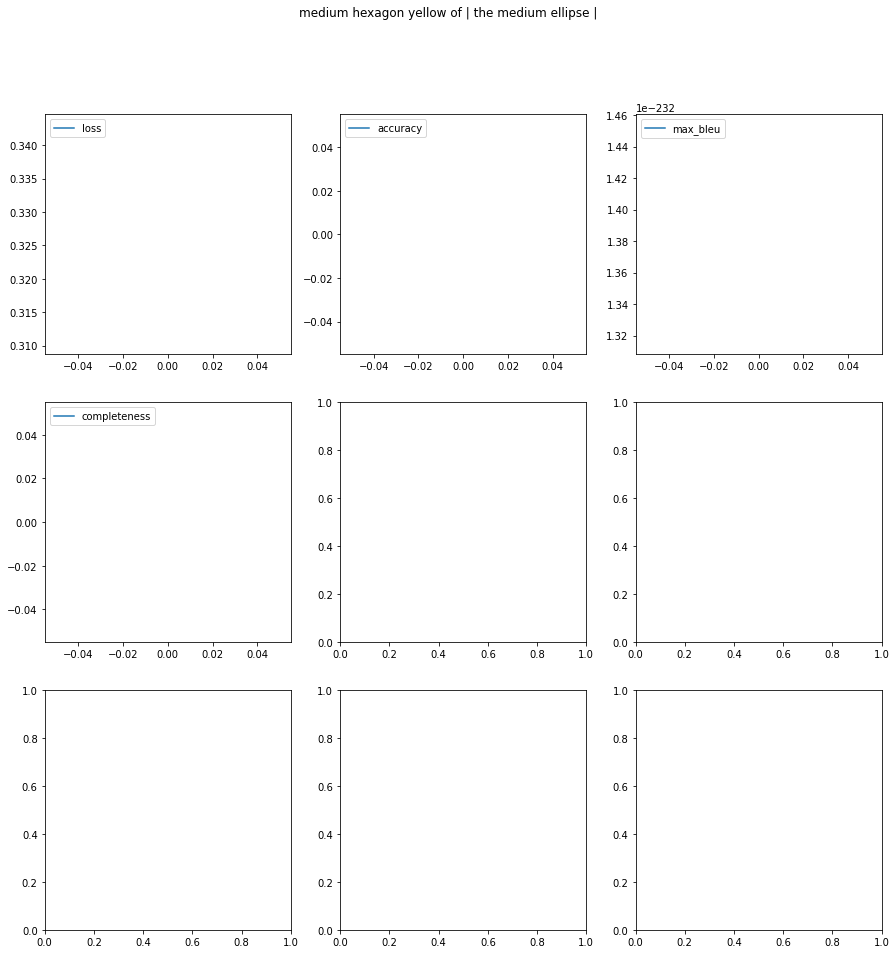

KeyboardInterrupt: 

In [35]:
import random
from tqdm.auto import tqdm
from IPython.display import clear_output

stats = []

for epoch_idx in range(1):
    # training
    random.shuffle(trainspl_sit_id)
    pbar = tqdm(enumerate(trainspl_sit_id), total=len(trainspl_sit_id))
    
    print('force_p:', force_p_schedule(epoch_idx))
    
    for i, vals in enumerate(stats):
        print(i, vals)
    
    avg_loss = 0.0
    num_correct = 0
    
    mbleu_avg = RunningAvg(10)
    
    for iter_idx, sit_id in pbar:
        utter_ids = sid2uids[sit_id]
        #print(sit_id, utter_ids)

        target_utters = id_select(utter_ids, utterances)
        
        input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'
        
        #tu = feedback_target(input_sit_str, target_utters, epoch_idx)
        #tu = closest_target(input_sit_str, target_utters, epoch_idx)
        tu = random.choice(target_utters) + ' !'
        #tu = min(target_utters, key=lambda u:len(u)) + ' !'
        #tu = max(target_utters, key=lambda u:num_words(u)) + ' !'
        tu_target = v2.tokenize(tu)
        #print(tu_target)

        # train
        pred_ids, loss, logits_all = model_forward(input_sit_str, tu_target, epoch_idx)
        
        cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()
        
        #bleu = sentence_bleu([ref.split(' ') for ref in target_utters], v.decode(pred_ids))
        mbleu = mbleu_avg(max_bleu(v2.decode(pred_ids)[:-1], target_utters))
        
        #edit_sim = train_edit_run(jaro_similarity(tu.replace('!', '').strip(), cleaned_pred))
        
        #print('loss: %.3f | "%s" | "%s"' % (loss.item()/len(pred_ids), cleaned_pred, tu.replace('!', '').strip()))
        
        #loss /= len(pred_ids)
        
        avg_loss += loss.item()
        
        plot.add(loss = train_loss_run(loss.item()/len(pred_ids)), accuracy = num_correct/(iter_idx + 1), max_bleu=mbleu)
        
        if iter_idx % 300 == 0:
            completeness = build_completeness(logits_all, target_utters, verbose=False, k=4)
            plot.add(completeness = completeness)
        
        if iter_idx % 500 == 0:
            eta = ''
            if pbar.format_dict['rate'] != None:
                eta = (pbar.format_dict['total'] - iter_idx) / pbar.format_dict['rate']
            plot.output_show(suptitle=(cleaned_pred + " | " + tu.replace('!', '').strip() + " | " + str(eta)),
                             subplots=(3, 3),
                             figsize=(15, 15))
            #clear_output(wait=True)
        
        if cleaned_pred in target_utters:
            #print('CORRECT')
            num_correct += 1
        
        loss.backward()
        opt_dec.step()
        opt_enc.step()

        #print(is_correct(cleaned_pred, target_utters))
        
        #loss = is_correct(cleaned_pred, target_utters) * loss

        opt_dec.zero_grad()
        opt_enc.zero_grad()
    
        if iter_idx % 500 == 0 and iter_idx != 0:
            # validation
            avg_valid_loss = 0.0
            avg_valid_correct = 0
            avg_valid_edit = 0.0
            avg_valid_comp = 0.0
            avg_valid_bleu = 0.0
            
            for iter_idx, sit_id in tqdm(enumerate(validspl_sit_id), total=len(validspl_sit_id)):
                utter_ids = sid2uids[sit_id]

                target_utters = id_select(utter_ids, utterances)

                #tu = random.choice(target_utters) + ' !'
                #tu = min(target_utters, key=lambda u:len(u)) + ' !'
                tu = max(target_utters, key=lambda u:num_words(u)) + ' !'
                tu_target = v2.tokenize(tu)

                input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'

                pred_ids, loss, logits_all = model_forward(input_sit_str, tu_target, epoch_idx, grad=False, force=False, pred=True)

                cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()

                #topk_preds = viterbi_predict_topk(input_sit_str, max_length=20, top_k=20)
                #avg_valid_comp += check_completeness(input_sit_str, topk_preds, target_utters)
                
                #print(', '.join(topk_preds))
                
                #bleu = sentence_bleu([ref.split(' ') for ref in target_utters], v.decode(pred_ids))

                #avg_valid_edit += jaro_similarity(tu.replace('!', '').strip(), cleaned_pred)

                loss /= len(pred_ids)
                
                avg_valid_loss += loss.item()

                avg_valid_bleu += max_bleu(v2.decode(pred_ids[:-1]), target_utters)
                
                if cleaned_pred in target_utters:
                    avg_valid_correct += 1
                
                #avg_valid_comp += build_completeness(logits_all, target_utters, verbose=False, k=4)
                
            avg_valid_loss /= len(validspl_sit_id)
            avg_valid_correct /= len(validspl_sit_id)
            avg_valid_edit /= len(validspl_sit_id)
            avg_valid_comp /= len(validspl_sit_id)
            avg_valid_bleu /= len(validspl_sit_id)
            #avg_valid_comp /= len(validspl_sit_id)

            plot.add(valid_loss=avg_valid_loss, valid_correct=avg_valid_correct, valid_bleu=avg_valid_bleu)
            
            print(avg_valid_correct)

In [ ]:
assert False

In [57]:
import json
import os

DIRECTORY = 'random_5e-4'

if not os.path.isdir(DIRECTORY):
    os.mkdir(DIRECTORY)
else:
    raise Exception('Directory already exists')

with open('%s/stats_1.json' % DIRECTORY, 'w') as file_out:
    json.dump(plot.stats, file_out)

with open('%s/out.txt' % DIRECTORY, 'w') as file_out:
    for sit_id in random.choices(validspl_sit_id, k=100):
        utter_ids = sid2uids[sit_id]

        target_utters = id_select(utter_ids, utterances)

        #tu = random.choice(target_utters) + ' !'
        #tu = min(target_utters, key=lambda u:len(u)) + ' !'
        tu = max(target_utters, key=lambda u:num_words(u)) + ' !'
        tu_target = v2.tokenize(tu)

        input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'

        pred_ids, loss, _ = model_forward(input_sit_str, tu_target, epoch_idx, grad=False, force=False, pred=True)

        cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()

        file_out.write('\nTARGET: ' + tu.replace('!', '').strip() + '\n')
        file_out.write('PREDICTION: ' + cleaned_pred + '\n')

torch.save(enc.state_dict(), '%s/enc.bin' % DIRECTORY)
torch.save(dec.state_dict(), '%s/dec.bin' % DIRECTORY)

Exception: Directory already exists

In [97]:
enc.load_state_dict(torch.load('feedback_ln_fixlbl2_soseos_full_every_1e-4/enc.bin'))
dec.load_state_dict(torch.load('feedback_ln_fixlbl2_soseos_full_every_1e-4/dec.bin'))

<All keys matched successfully>

In [98]:
from torch.distributions.categorical import Categorical

temperature = 3.0
do_opt = True
total_samples = 1000
total_repeat = 1

opt_enc_infer = optim.Adam(enc.parameters(), lr=1e-5)
opt_dec_infer = optim.Adam(dec.parameters(), lr=1e-5)

for _ in tqdm(range(total_repeat)):
    for tune_iter, sit_id in enumerate(trainspl_sit_id):
        if tune_iter >= total_samples:
            break

        utter_ids = sid2uids[sit_id]
        target_utters = id_select(utter_ids, utterances)
        input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'

        print('%d: INPUT: %s | TARGET: %s' % (tune_iter, input_sit_str, max(target_utters, key=lambda x: len(x))))

        distinct_correct = set()

        for sample_iter in range(100):
            # begin sampling
            input_sit = v1.tokenize(input_sit_str)
            enc_out, enc_hidden = enc(input_sit)

            logprob = 0.0
            pred_ids = []
            logits_all = []
            prev = start_id
            h = enc_hidden
            for i in range(13):
                logits, h = dec(prev, enc_hidden, h, enc_out)

                probs = Categorical(F.softmax(logits[0] / temperature, dim=0))

                prev = probs.sample()
                pred_ids.append(prev)

                logits_all.append(logits)

                logprob += -F.cross_entropy(logits, prev.unsqueeze(0))

                if prev == eos_id:
                    break

            cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()
            print('SAMPLE:', cleaned_pred)

            if cleaned_pred in target_utters:
                distinct_correct.add(cleaned_pred)
                print('SAMPLE CORRECT #%d' % len(distinct_correct))

                loss = -logprob
            else:
                print('SAMPLE INCORRECT')
                loss = logprob

            loss.backward()

            if do_opt:
                opt_enc_infer.step()
                opt_dec_infer.step()

            opt_enc_infer.zero_grad()
            opt_dec_infer.zero_grad()


  0%|          | 0/1 [00:00<?, ?it/s]

0: INPUT: ^ bi1(x1) re1(x1) ci1(x1) ab2(x1,x2) sm1(x2) re1(x2) st1(x2) ! | TARGET: the big red circle above the small red star
SAMPLE: the big right to big red circle
SAMPLE INCORRECT
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big circle triangle
SAMPLE INCORRECT
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle hexagon
SAMPLE INCORRECT
SAMPLE: the big triangle
SAMPLE INCORRECT
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: to big red circle
SAMPLE INCORRECT
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1


SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big green orange star
SAMPLE INCORRECT
SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big green star
SAMPLE CORRECT #3
SAMPLE: the big small green star
SAMPLE INCORRECT
SAMPLE: the big green star
SAMPLE CORRECT #3
2: INPUT: ^ me1(x1) re1(x1) he1(x1) ab2(x1,x2) me1(x2) gr1(x2) st1(x2) ! | TARGET: the medium green star below the medium red hexagon
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon big star
SAMPLE INCORRECT
SAMPLE: the medium red right red hexagon
SAMPLE INCORRECT
SAMPLE: the medium red to to red hexagon
SAMPLE INCORRECT
SAMPLE: the medium red red hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE

SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle red circle
SAMPLE INCORRECT
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the left green circle
SAMPLE INCORRECT
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the small big green circle
SAMPLE INCORRECT
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SA

SAMPLE: the small orange hexagon the small above hexagon
SAMPLE INCORRECT
SAMPLE: the small to hexagon
SAMPLE INCORRECT
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon circle
SAMPLE INCORRECT
SAMPLE: to medium star
SAMPLE INCORRECT
SAMPLE: the small medium small orange hexagon
SAMPLE INCORRECT
SAMPLE: the small hexagon
SAMPLE CORRECT #2
SAMPLE: the small orange hexagon
SAMPLE CORRECT #2
SAMPLE: the small orange hexagon below hexagon
SAMPLE INCORRECT
SAMPLE: the small big ^ hexagon
SAMPLE INCORRECT
SAMPLE: the small orange hexagon
SAMPLE CORRECT #2
SAMPLE: the small square
SAMPLE INCORRECT
SAMPLE: the small orange hexagon
SAMPLE CORRECT #2
SAMPLE: the small orange of circle
SAMPLE INCORRECT
SAMPLE: the small orange hexagon
SAMPLE CORRECT #2
SAMPLE: the small orange hexagon
SAMPLE CORRECT #2
SAMPLE: the small orange hexagon
SAMPLE CORRECT #2
SAMPLE: left small orange hexagon
SAMPLE INCORRECT
SAMPLE: the small orange hexagon yellow hexagon
SAMPLE INCORR

SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon red hexagon
SAMPLE INCORRECT
SAMPLE: the big orange blue hexagon
SAMPLE INCORRECT
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big star orange hexagon
SAMPLE INCORRECT
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the b

SAMPLE: the small the small purple triangle
SAMPLE INCORRECT
SAMPLE: the small big purple triangle
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle the small purple triangle
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: green triangle
SAMPLE INCORRECT
SAMPLE: the below triangle
SAMPLE INCORRECT
SAMPLE: the star
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the purple triangle
SAMPLE CORRECT #3
SAMPLE: right yellow triangle
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #3
SAMPLE: the small purple triangle
SAMPLE CORRECT #3
SAMPLE: the small purple yellow triangle
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #3
SAMPLE: the small ellipse
SAMPLE INCORRECT
SAMPLE: the small purple t

SAMPLE: the small red hexagon
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the above hexagon
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: hexagon medium small blue hexagon
SAMPLE INCORRECT
SAMPLE: the small circle
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small below hexagon
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue hexagon
SAMPLE CORRECT #2
SAMPLE: the small blue he

SAMPLE: the the big yellow square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square big green square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big ellipse red square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square below square
SAMPLE INCORRECT
SAMPLE: the to of square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big below square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green small g

SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: blue circle
SAMPLE INCORRECT
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium square
SAMPLE INCORRECT
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
14: INPUT: ^ sm1(x1) pu1(x1) st1(x1) ab2(x1,x2) bi1(x2) ye1(x2) st1(x2) ! | TARGET: the small purple star above the big yellow star
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the yellow star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star left purple star
SAMPLE INCORRECT
SAMPLE: the big purple star
SAMPLE INCORRECT
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the big orange star
SAMPLE INCORRECT
SAMPLE: the small purple star
SAMPLE CORRECT #

SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the square
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red square square
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: green hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: of hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SA

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium circle
SAMPLE INCORRECT
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse purple ellipse
SAMPLE INCORRECT
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: above below ellipse
SAMPLE INCORRECT
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: of ellipse
SAMPLE INCORRECT
SAMPLE: the medium orange small medium orange ellipse
SAMPLE INCORRECT
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the square
SAMPLE INCORRECT
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE INCORRECT
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CO

SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon triangle
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the green hexagon
SAMPLE INCORRECT
SAMPLE: the small red ellipse
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small triangle
SAMPLE INCORR

SAMPLE INCORRECT
21: INPUT: ^ sm1(x1) gr1(x1) sq1(x1) ab2(x1,x2) sm1(x2) re1(x2) he1(x2) ! | TARGET: the small red hexagon below the small green square
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the red square
SAMPLE INCORRECT
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small medium green square
SAMPLE INCORRECT
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small 

SAMPLE: the big of ellipse
SAMPLE INCORRECT
SAMPLE: the big square
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the small orange ellipse
SAMPLE INCORRECT
SAMPLE: orange ^ the big orange ellipse
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange below ellipse
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big red ellipse
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big hexagon square
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange ellipse
SAMPLE CORRECT #3
SAMPLE: the big orange el

SAMPLE: the big orange circle
SAMPLE INCORRECT
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple ellipse
SAMPLE INCORRECT
SAMPLE: the big purple circle
SAMPLE INCORRECT
SAMPLE: small big big purple left the big purple yellow square
SAMPLE INCORRECT
SAMPLE: the yellow square
SAMPLE INCORRECT
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple squ

SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium small medium green ellipse
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the hexagon to ellipse
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium gre

SAMPLE: the medium green red star
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green above star
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green blue star
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE CORRECT #2
SAMPLE: the medium below star
SAMPLE INCORRECT
28: INPUT: ^ sm1(x1) or1(x1) el1(x1) le2(x1,x2) sm1(x2) pu1(x2) sq1(x2) ! | TARGET: the small purple square to the right of the small orange ellipse
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small ora

SAMPLE: the big orange red triangle
SAMPLE INCORRECT
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the big orange circle
SAMPLE INCORRECT
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: hexagon
SAMPLE INCORRECT
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE INCORRECT
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big ^ the big orange triangle
SAMPLE INCORRECT
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAM

SAMPLE: to circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle big blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue star
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: blue circle
SAMPLE INCORRECT
SAMPLE: the medium medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium star
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPL

SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the red triangle
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the small orange ellipse
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #3
SAMPLE: the right green triangle
SAMPLE INCORRECT
SAMPLE: the small orange triangle to triangle
SAMPLE INCORRECT
33: INPUT: ^ me1(x1) or1(x1) el1(x1) ab2(x1,x2) sm1(x2) ye1(x2) ci1(x2) ! | TARGET

SAMPLE: the small red hexagon
SAMPLE CORRECT #3
SAMPLE: the purple hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow red hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the
SAMPLE INCORRECT
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the medium small yellow of
SAMPLE INCORRECT
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #3
SAMPLE: 

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the green circle
SAMPLE INCORRECT
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big medium above circle
SAMPLE INCORRECT
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big ellipse
SAMPLE INCORRECT
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the to green circle
SAMPLE INCORRECT
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAM

SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
38: INPUT: ^ me1(x1) re1(x1) st1(x1) ab2(x1,x2) me1(x2) gr1(x2) tr1(x2) ! | TARGET: the medium red star above the medium green triangle
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: ^ the medium red purple left
SAMPLE INCORRECT
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the me

SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue big small blue triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMP

SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE INCORRECT
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the square
SAMPLE INCORREC

SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE INCORRECT
SAMPLE: the small below star
SAMPLE INCORRECT
SAMPLE: the right ellipse
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE CORRECT #1

SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon orange hexagon
SAMPLE INCORRECT
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE INCORRECT
45: INPUT: ^ bi1(x1) ye1(x1) tr1(x1) le2(x1,x2) me1(x2) re1(x2) sq1(x2) ! | TARGET: the medium red square to the right of the big yellow triangle
SAMPLE: hexagon
SAMPLE INCORRECT
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the ^ the big yellow triangle
SAMPLE INCORRECT
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big ellipse
SAMPLE INCORRECT
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMP

SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the ^ the medium hexagon
SAMPLE INCORRECT
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the big orange square
SAMPLE INCORRECT
SAMPLE: the medium orange medium
SAMPLE INCORRECT
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the ^ the medium orange square
SAMPLE INCORRECT
SAMPLE: the medium orange square
SAMPLE CORRECT #2
SAMPLE: the medium orange square

SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: to square
SAMPLE INCORRECT
SAMPLE: red square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE 

SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
SAMPLE: the small red circle
SAMPLE CORRECT #3
50: INPUT: ^ bi1(x1) ye1(x1) st1(x1) ab2(x1,x2) sm1(x2) ye1(x2) st1(x2) ! | TARGET: the big yellow star above the small yellow star
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the the big yellow star
SAMPLE INCORRECT
SAMPLE: the big yellow square big yellow star
SAMPLE INCORRECT
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the medium red star
SAMPLE CORRECT #2
SAMPLE: the medium red orange star
SAMPLE INCORRECT
SAMPLE: the medium red star
SAMPLE CORRECT #2
SAMPLE: the medium green star
SAMPLE INCORRECT
SAMPLE: the medium red small red star
SAMPLE INCORRECT
SAMPLE: the medium red star
SAMPLE CORRECT #2
SAMPLE: the medium red star
SAMPLE CORRECT #2
SAMPLE: the medium red star
SAMPLE CORRECT #2
SAMPLE: the medium red star
SAMPLE CORRECT #2
SAMPLE: the star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: hexagon
SAMPLE INCORRECT
SAMPLE: the orange star
SAMPLE INCORRECT
SAMPLE: the medium red circle
SAMPLE INCORRECT
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red green star
SAMPLE INCORRECT
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORREC

SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the ^ the medium red triangle right triangle
SAMPLE INCORRECT
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE INCORRECT
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE INCORRECT
SAMPLE: the big red triangle
SAMPLE CORRE

SAMPLE: of triangle
SAMPLE INCORRECT
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the m

SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the below square
SAMPLE INCORRECT
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE 

SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big purple right star
SAMPLE INCORRECT
SAMPLE: the big yellow star
SAMPLE INCORRECT
SAMPLE: the big small purple star
SAMPLE INCORRECT
SAMPLE: the big purple star
SAMPLE CORRECT #3
SAMPLE: the big small purple star
SAMPLE INCORRECT
SAMPLE: the big purple s

SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle hexagon
SAMPLE INCORRECT
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium to triangle
SAMPLE INCORRECT
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE INCORRECT
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium star circle
SAMPLE INCORRECT
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
62: INPUT: ^ me1(x1) gr1(x1) sq1(x1) ab2(x1,x2) me1(x2) bl1(x2) sq1(x2) ! | TARGET: the medium green square above the medium blue square
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green left square
SAMPLE INCORRECT
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE INCORRECT
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium orange circle
SAMPLE INCORRECT
SAMPLE: the left circle
SAMPLE INCORRECT
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: to circle
SAMPLE INCORRECT
SAMPLE: the medium yellow circle
SAMPLE INCORRECT
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium right circle
SAMPLE INCORRECT
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: th

SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE INCORRECT
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the yellow hexagon
SAMPLE INCORRECT
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPL

67: INPUT: ^ me1(x1) bl1(x1) sq1(x1) le2(x1,x2) sm1(x2) bl1(x2) tr1(x2) ! | TARGET: the small blue triangle to the right of the medium blue square
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the orange square
SAMPLE INCORRECT
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square above square
SAMPLE INCORRECT
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the me

SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle ellipse
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple green triangle
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2


SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium hexagon
SAMPLE INCORRECT
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium the left star
SAMPLE INCORRECT
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium the medium blue star
SAMPLE INCORRECT
SAMPLE: the medium blue hexagon
SAMPLE INCORRECT
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE INCORRECT
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star yellow star
SAMPLE INCORRECT
SAMPLE: the medium triangle
SAMPLE INCORRE

SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small left triangle
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow right triangle
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium yellow hexagon
SAMPLE INCORRECT
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple triangle
SAMPLE INCORRECT
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #3
74: INPUT: ^ 

SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small of star
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow to star
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRE

SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green orange square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big of square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the small yellow big small triangle
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
79: INPUT: ^ bi1(x1) re1(x1) el1(x1) ab2(x1,x2) sm1(x2) bl1(x2) he1(x2) ! | TARGET: the big red ellipse above the small blue hexagon
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE INCORRECT
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium ellipse
SAMPLE INCORRECT
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow orange triangle
SAMPLE INCORRECT
SAMPLE: the small yellow left small yellow triangle
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the purple triangle
SAMPLE INCORRECT
SAMPLE: the small yellow hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the sma

SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small triangle
SAMPLE INCORRECT
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the smal

SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: big red hexagon
SAMPLE INCORRECT
SAMPLE: the small red medium triangle
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the above hexagon
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red orange hexagon
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: ellipse
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the ellipse
SAMPLE INCORRECT
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small

SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
86: INPUT: ^ bi1(x1) gr1(x1) tr1(x1) le2(x1,x2) sm1(x2) ye1(x2) he1(x2) ! | TARGET: the small yellow hexagon to the right of the big green triangle
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE INCORRECT
SAMPLE: the big yellow triangle
SAMPLE INCORRECT
SAMPLE: the big gre

SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2


SAMPLE: the of square
SAMPLE INCORRECT
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small left square
SAMPLE INCORRECT
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small big red square
SAMPLE INCORRECT
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small to square
SAMPLE INCORRECT
SAMPLE: the small red left below of square
SAMPLE INCORRECT
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: circle
SAMPLE INCORRECT
SAMPLE: the small red 

SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORR

SAMPLE: the big orange ellipse
SAMPLE INCORRECT
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse hexagon
SAMPLE INCORRECT
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
93: INPUT: ^ sm1(x1) or1(x1) ci1(x1) ab2(x1,x2) bi1(x2) pu1(x2) sq1(x2) ! | TARGET: the small orange circle above the big purple square
SAMPLE: the small orange ci

SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green below triangle
SAMPLE INCORRECT
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the orange triangle
SAMPLE INCORRECT
SAMPLE: the small the small green triangle
SAMPLE INCORRECT
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green blue triangle
SAMPLE INCORRECT
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small square
SAMPLE INCORRECT
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green tria

SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium yellow triangle
SAMPLE INCORRECT
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triang

SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green left hexagon
SAMPLE INCORRECT
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: to hexagon
SAMPLE INCORRECT
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE INCORRECT
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE INCORRECT
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the s

SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple yellow triangle
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle circle
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the small purple triangle the small purple tria

SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small hexagon
SAMPLE INCORRECT
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green yellow square
SAMPLE INCORRECT
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small gr

SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle purple triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big right triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the left triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium small yellow triangle
SAMPLE INCORRECT
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE

SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium green square
SAMPLE INCORRECT
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square


SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the orange ^ the small purple ellipse
SAMPLE INCORRECT
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small p

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow blue circle
SAMPLE INCORRECT
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT

SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small blue star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the below the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPL

SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red to triangle
SAMPLE INCORRECT
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE INCORRECT
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red

SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red the hexagon
SAMPLE INCORRECT
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small right circle
SAMPLE INCORRECT
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE INCORRECT
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE:

SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange blue circle
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange right circle
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
117: INPUT: ^ me1(x1) gr1(x1) tr1(x1) ab2(x1

SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle ellipse
SAMPLE INCORRECT
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMPLE: the big red triangle
SAMPLE CORRECT #2
SAMP

SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the small green triangle
SAMPLE INCORRECT
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big right triangle
SAMPLE INCORRECT
SAMPLE: the big green triangle
SAMPLE CORRECT #2
SAMPLE: the big green blue triangle
SAMPLE INCORRECT
SAMPLE: the big 

SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: hexagon
SAMPLE INCORRECT
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
SAMPLE: the big green circle
SAMPLE CORRECT #2
122: INPUT: ^ bi1(x1) pu1(x1) el1(x1) le2(x1,x2) me1(x2) pu1(x2) st1(x2) ! | TARGET: the medium purple star to the right of the big purple ellipse
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the medium below ellipse
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green orange ellipse
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse purple ellipse
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red orange star
SAMPLE INCORRECT
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: small red star
SAMPLE INCORRECT
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: t

SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
127: INPUT: ^ me1(x1) gr1(x1) tr1(x1) ab2(x1,x2) bi1(x2) re1(x2) ci1(x2) ! | TARGET: the medium green triangle above the big red circle
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
S

SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star small green star
SAMPLE INCORRECT
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the triangle
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green small green star
SAMPLE INCORRECT
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE 

SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium big blue triangle
SAMPLE INCORRECT
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium orange triangle
SAMPLE INCORRECT
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue green triangle
SAMPLE INCORRECT
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium yellow triangle
SAMPLE INCORRECT
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium medium blue triangle
SAMPLE INCORRECT
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blue triangle
SAMPLE CORRECT #3
SAMPLE: the medium blu

SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small ellipse
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange 

SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE CORRECT #2
134: INPUT: ^ sm1(x1) bl1(x1) el1(x1) le2(x1,x2) me1(x2) bl1(x2) he1(x2) ! | TARGET: the medium blue hexagon to the right of the small blue ellipse
SA

SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: ^ the small red triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMPLE INCORRECT
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small r

SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the ^ the big circle
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: below ellipse
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the orange above ellipse
SAMPLE INCORRECT
SAMPLE: the ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange ellipse
SAMPLE CORRECT #2
SAMPLE: the big orange the big orange ellip

SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
139: INPUT: ^ me1(x1) gr1(x1) ci1(x1) le2(x1,x2) bi1(x2) ye1(x2) el1(x2) ! | TARGET: the big yellow ellipse to the right of the medium green circle
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE INCORRECT
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE INCORRECT
SAMPLE: the medium green circle
SA

SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle orange triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue yellow triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the green triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE CORRECT #3
SAMPLE: the small blue triangle
SAMPLE

SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle big green circle
SAMPLE INCORRECT
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMP

144: INPUT: ^ me1(x1) ye1(x1) he1(x1) ab2(x1,x2) me1(x2) or1(x2) tr1(x2) ! | TARGET: the medium orange triangle below the medium yellow hexagon
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the of hexagon
SAMPLE INCORRECT
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: ^ the medium yellow hexagon
SAMPLE INCORRECT
SAMPLE: hexagon
SAMPLE INCORRECT
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SA

SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red square
SAMPLE INCORRECT
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big star
SAMPLE INCORRECT
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the orange ellipse
SAMPLE INCORRECT
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2
SAMPLE: the big red ellipse
SAMPLE CORRECT #2


SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the small purple square
SAMPLE INCORRECT
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE 

SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
149: INPUT: ^ me1(x1) ye1(x1) el1(x1) ab2(x1,x2) bi1(x2) bl1(x2) ci1(x2) ! | TARGET: the big blue circle below the medium yellow ellipse
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium star
SAMPLE INCORRECT
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the m

SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small square
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purp

SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium the medium blue square
SAMPLE INCORRECT
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CO

SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE INCORRECT
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE INCORRECT
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE C

SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
156: INPUT: ^ me1(x1) ye1(x1) ci1(x1) le2(x1,x2) bi1(x2) gr1(x2) sq1(x2) ! | TARGET: the big green square to the right of the medium yellow circle
SAMPLE: the square
SAMPLE CORRECT #1
SAMPLE: the medium yellow cir

SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the right circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the right circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAM

SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE INCORRECT
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the triangle
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRE

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
161: INPUT: ^ sm1(x1) re1(x1) st1(x1) le2(x1,x2) bi1(x2) ye1(x2) tr1(x2) ! | TARGET: the big yellow triangle to the right of the small red star
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: 
SAMPLE INCORRECT
SAMPLE: the small red star
SAMPLE C

SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big ^ the big orange triangle
SAMPLE INCORRECT
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CO

SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow above of square
SAMPLE INCORRECT
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small to square
SAMPLE INCORRECT
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT 

SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE INCORRECT
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange small
SAMPLE INCORRECT
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the blue star
SAMPLE INCORRECT
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the hexagon left star
SAMPLE INCORRECT
SAMPLE: the big hexagon
SAMPLE INCORRECT
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1


SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
168: INPUT: ^ bi1(x1) bl1(x1) e

SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium star
SAMPLE INCORRECT
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple 

SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange green square
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange above square
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE INCORRECT
SAMPLE: right small orange square
SAMPLE INCORRECT
SAMPLE: the big of square
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAM

SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue square
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium square
SAMPLE INCORRECT
SAMPLE: the ^ the medium the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE INCORRECT
SAMPL

SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium red star
SAMPLE CORRECT #3
SAMPLE: the medium ellipse
SAMPLE INCORRECT
175: INPUT: ^ sm1(x1) re1(x1) el1(x1) le2(x1,x2) sm1(x2) pu1(x2) he1(x2) ! | TARGET: the small purple hexagon to the right of the small red ellipse
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red el

SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small medium orange ellipse
SAMPLE INCORRECT
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the below ellipse
SAMPLE INCORRECT
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse
SAMPLE CORRECT #2
SAMPLE: the small orange ellipse


SAMPLE: the medium above triangle
SAMPLE INCORRECT
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE INCORRECT
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE INCORRECT
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1

SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse triangle
SAMPLE INCORRECT
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
180: INPUT: ^ sm1(x1) gr1(x1) tr1(x1) le2(x1,x2) me1(x2) ye1(x2) tr1(x2) ! | TARGET: the medium yellow triangle to the right of the small green triangle
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the the small green triangle
SAMPLE INCORRECT
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small gr

SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE INCORRECT
SAMPLE: the big left square
SAMPLE INCORRECT
SAMPLE: the big the orange square
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange green square
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPL

SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange
SAMPLE INCORRECT
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE INCORRECT
SAMPLE: the small orange ellipse
SAMPLE COR

SAMPLE: the medium to triangle
SAMPLE INCORRECT
SAMPLE: the small orange yellow triangle
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the star
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
185: INPUT: ^ bi1(x1) gr1(x1) ci1(x1) ab2(x1,x2) bi1(x2) re1(x2) sq1(x2) ! | TARGET: the big green circle above the big red square
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE 

SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium the medium blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium triangle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the me

SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big star
SAMPLE INCORRECT
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big small square
SAMPLE INCORRECT
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big to hexagon
SAMPLE INCORRECT
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE C

SAMPLE: the purple triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red below triangle
SAMPLE INCORRECT
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the below triangle
SAMPLE INCORRECT
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red triangle
SAMPLE CORRECT #2
SAMPLE: the small red t

SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: blue hexagon
SAMPLE INCORRECT
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE INCORRECT
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE INCORRE

SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big below circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the orange circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE INCORRECT
SAMPLE: the

SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium square
SAMPLE INCORRECT
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE INCORRECT
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium gree

SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the square
SAMPLE CORRECT #2
SAMPLE: the medium red hexagon
SAMPLE CORRECT #2
SAMPLE: the medium red hexagon
SAMPLE CORRECT #2
SAMPLE: the medium red hexagon
SAMPLE CORRECT #2
SAMPLE: the medium red hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #2
SAMPLE: the medium red hexagon
SAMPLE CORRECT #2
SAMPLE: the medium red hexagon
SAMPLE CORRECT #2
SAMPLE: the medium red hexagon

SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square the small blue square
SAMPLE INCORRECT
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small p

SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SA

SAMPLE: the small yellow hexagon
SAMPLE INCORRECT
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE INCORRECT
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #2
SAMPLE: the big yello

SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small hexagon
SAMPLE INCORRECT
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the star
SAMPLE INCORRECT
SAMPLE: the small orang

SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
SAMPLE: the medium green circle
SAMPLE CORRECT #2
206: INPUT: ^ me1(x1) pu1(x1) tr1(x1) ab2(x1,x2) me1(x2) 

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the the red star
SAMPLE INCORRECT
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small 

SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
209: INPUT: ^ bi1(x1) or1(x1) he1(x1) ab2(x1,x2) sm1(x2) gr1(x2) he1(x2) ! | TARGET: the small green hexagon below the big orange hexagon
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big medium orange hexagon
SAMPLE INCORRECT
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE INCORRECT
SAMPLE: the big hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexagon
SAMPLE CORRECT #2
SAMPLE: the big orange hexa

SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the of star
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
S

SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green big green hexagon
SAMPLE INCORRECT
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium gre

SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORR

SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
216: INPUT: ^ me1(x1) pu1(x1) el1(x1) ab2(x1,x2) bi1(x2) bl1(x2) sq1(x2) ! | TARGET: the big blue square below the medium purple ellipse
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse yellow ellipse
SAMPLE INCORRECT
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple above ellipse
SAMPLE INCORRECT
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE C

SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple triangle
SAMPLE INCORRECT
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the small purple hexagon
SAMPLE CORRECT #2
SAMPLE: the medium purple hexagon
SAMPLE INC

SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange below circle
SAMPLE INCORRECT
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange small orange circle
SAMPLE INCORRECT
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circle
SAMPLE CORRECT #2
SAMPLE: the big orange circ

SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellips

SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
SAMPLE: the big purple circle
SAMPLE CORRECT #2
223: INPUT: ^ bi1(x1) gr1(x1) ci1(x1) ab2(x1,x2) sm1(x2) re1(x2) tr1(x2) ! | TARGET: the

SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE INCORRECT
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPL

SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAM

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORR

SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexagon
SAMPLE CORRECT #2
SAMPLE: the medium green hexago

SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small
SAMPLE INCORRECT
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triang

SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE INCORRECT
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
233: INPUT: ^ me1(x1) gr1(x1) tr1(x1) ab2(x1,x2) bi1(x2) gr1(x2) he1(x2) ! | TARGET: the big green hexagon below the medium green triangle
SAMPLE: the
SAMPLE INCORRECT
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green above triangle
SAMPLE INCORRECT
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the mediu

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE INCORRECT
SAMPLE: the to circle
SAMPLE INCORRECT
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE INCORRECT
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small hexagon
SAMPLE INCORRECT
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small

SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE INCORRECT
238: INPUT: ^ me1(x1) pu1(x1) he1(x1) ab2(x1,x2) sm1(x2) pu1(x2) tr1(x2) ! | TARGET: the small purple triangle below the medium purple hexagon
SAMPLE: the square
SAMPLE INCORRECT
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium of hexagon
SAMPLE INCORRECT
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple above hexagon
SAMPLE INCORRECT
SAMPLE: the medium purple hexagon
SAMPLE COR

SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple hexagon
SAMPLE INCORRECT
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2
SAMPLE: the medium purple triangle
SAMPLE CORRECT #2

SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE INCORRECT
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SA

SAMPLE: the green star
SAMPLE INCORRECT
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
243: INPUT: ^ sm1(x1) pu1(x1) st1(x1) le2(x1,x2) bi1(x2) gr1(x2) st1(x2) ! | TARGET: the big green star to the right of the small purple star
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple to star
SAMPLE INCORRECT
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1


SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star right star
SAMPLE INCORRECT
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2
SAMPLE: the big green star
SAMPLE CORRECT #2


SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the orange star
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1

SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the below square
SAMPLE INCORRECT
SAMPLE: the yellow square
SAMPLE INCORRECT
250: INPUT: ^ sm1(x1) gr1(x1) ci1(x1) ab2(x1,x2) bi1(x2) gr1(x2) tr1(x2) ! | TARGET: the big green triangle below the small green circle
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1


SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the above circle
SAMPLE INCORRECT
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #

SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the yellow square
SAMPLE INCORRECT
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT 

SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the yellow star
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green right star
SAMPLE INCORRECT
SAMPLE: the above star
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1


SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORR

SAMPLE: the above star
SAMPLE INCORRECT
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE INCORRECT
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star

SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE INCORRECT
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow to ellipse
SAMPLE INCORRECT
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE COR

SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORRECT #2
SAMPLE: the medium orange triangle
SAMPLE CORR

SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple yellow star
SAMPLE INCORRECT
SAMPLE: the medium circle
SAMPLE INCORRECT
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium p

SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE

SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the red hexagon
SAMPLE INCORRECT
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blu

SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
269: INPUT: ^ me1(x1

SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium hexagon
SAMPLE INCORRECT
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium red star
SAMPLE INCORRECT
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPL

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #2
SAMPLE: the 

274: INPUT: ^ sm1(x1) bl1(x1) st1(x1) le2(x1,x2) me1(x2) pu1(x2) el1(x2) ! | TARGET: the medium purple ellipse to the right of the small blue star
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: of star
SAMPLE INCORRECT
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the purple star
SAMPLE INCORRECT
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT 

SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE INCORRECT
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORR

SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the star
SAMPLE INCORRECT
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT 

SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE

SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
281: INPUT: ^ sm1(x1) pu1(x1) sq1(x1) ab2(x1,x2) bi1(x2) re1(x2) tr1(x2) ! | TARGET: the small purple square above the big red triangle
SAMPLE: the small small purple square
SAMPLE INCORRECT
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple
SAMPLE INCORRECT
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square

SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1


SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE COR

SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
286: INPUT: ^ sm1(x1) re1(x1) ci1(x1) le2(x1,x2) bi1(x2) bl1(x2) el1(x2) ! | TARGET: the big blue ellipse to the right of the small red circle
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium purple star
SAMPLE CORRECT #2
SAMPLE: the medium p

SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon square
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue small blue hexagon
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small

SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the sm

SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star ^ the big blue star
SAMPLE INCORRECT
293: INPUT: ^ bi1(x1) pu1(x1) st1(x1) le2(x1,x2) sm1(x2) bl1(x2) sq1(x2) ! | TARGET: the small blue square to the right of the big purple star
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big pu

SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium big orange circle
SAMPLE INCORRECT
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange ci

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: star
SAMPLE INCORRECT
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium ^ the medium orange hexagon
SAMPLE INCORRECT
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium pur

SAMPLE: the yellow ellipse
SAMPLE INCORRECT
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
300: INPUT: ^ me1(x1) or1(x1) st1(x1) le2(x1,x2) bi1(x2) ye1(x2) tr1(x2) ! | TARGET: the big yellow triangle to the right of the medium orange star
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: t

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE:

SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small triangle
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue right hexagon
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small bl

SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the s

SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE INCORRECT
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the ^ the small red star
SAMPLE INCORRECT
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red above right star
SAMPLE INCORRECT
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORR

SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue yellow triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue green triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle

SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green big green ellipse
SAMPLE INCORRECT
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
S

SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE INCORRECT
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAM

SAMPLE: the medium green circle
SAMPLE INCORRECT
SAMPLE: the medium green hexagon
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium square
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE INCORRECT
SAMPLE: the medium green star
SAMPLE CORRE

SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green the medium green hexagon
SAMPLE INCORRECT
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the med

SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the small red circle
SAMPLE CORRECT #1
SAMPLE: the s

SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the green circle
SAMPLE INCORRECT
SAMPLE: the small left circle
SAMPLE INCORRECT
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1

SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the right star
SAMPLE INCORRECT
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the triangle
SAMPLE INCORRECT
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SA

SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the yellow square
SAMPLE INCORRECT
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small above square
SAMPLE INCORRECT
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the smal

SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE

SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
326: INPUT: ^ bi1(x1) re1(x1) he1(x1) le2(x1,x2) sm1(x2) or1(x2) st1(x2) ! | TARGET: the small orange star to the right of the big red hexagon
SAMPLE: the big yellow hexagon
SAMPL

SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the triangle
SAMPLE INCORRECT
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big o

SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE COR

331: INPUT: ^ bi1(x1) ye1(x1) ci1(x1) le2(x1,x2) sm1(x2) gr1(x2) ci1(x2) ! | TARGET: the small green circle to the right of the big yellow circle
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the left circle
SAMPLE INCORRECT
SAMPLE: the big left circle
SAMPLE INCORRECT
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1


SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow
SAMPLE INCORRECT
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE

SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE INCORRECT
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CO

SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellips

SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium o

SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE

SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple green hexagon
SAMPLE INCORRECT
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big purple hexagon
SAMPLE CORRECT #2
SAMPLE: the big

SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
343: INPUT: ^ sm1(x1) or1(x1) ci1(x1) ab2(x1,x2) me1(x2) gr1(x2) ci1(x2) ! | TARGET: the small orange circle above the medium green circle
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium triangle
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMP

SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the the big green triangle
SAMPLE INCORRECT
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the star
SAMPLE INCORRECT
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
S

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the ^ the small green star
SAMPLE INCORRECT
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: 

SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the blue circle
SAMPLE INCORRECT
SAMPLE: the small orange square
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: triangle
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange c

SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small below star
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRE

SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple above star
SAMPLE INCORRECT
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple above 

SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
355: INPUT: ^ sm1(x1) or1(x1) he1(x1) ab2(x1,x2) sm1(x2) gr1(x2) he1(x2) ! | TARGET: the small orange hexagon above the small green hexagon
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small o

SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE

SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
S

SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small the small blue triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the green triangle
SAMPLE CORRECT #2
SAMPLE: the small blue triangle
SAMPLE CORRECT #2
SAMPLE: the small blue triangle
SAMPLE CORRECT

SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
SAMPLE: the big red hexagon
SAMPLE CORRECT #2
362: INPUT: ^ me1(x1) re1(x1) el1(x1) le2(x1,x2) me1(x2) re1(x2) el1(x2) ! | TAR

SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purp

SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE INCORRECT
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow ^ the big yellow square
SAMPLE INCORRECT
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow

SAMPLE: the small purple square
SAMPLE CORRECT #2
SAMPLE: the small purple square
SAMPLE CORRECT #2
SAMPLE: the small purple square
SAMPLE CORRECT #2
SAMPLE: the small purple square
SAMPLE CORRECT #2
SAMPLE: the small purple square
SAMPLE CORRECT #2
367: INPUT: ^ sm1(x1) gr1(x1) st1(x1) le2(x1,x2) me1(x2) bl1(x2) tr1(x2) ! | TARGET: the medium blue triangle to the right of the small green star
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE COR

SAMPLE: the medium yellow square
SAMPLE INCORRECT
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small medium yellow square
SAMPLE INCO

SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium r

SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big of square
SAMPLE INCORRECT
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the of sq

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORR

SAMPLE: the medium green square
SAMPLE INCORRECT
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
S

SAMPLE: the yellow triangle
SAMPLE INCORRECT
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE INCORRECT
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: ellipse
SAMPLE INCORRECT
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange

SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
SAMPLE: the small blue circle
SAMPLE CORRECT #1
379: INPUT: ^ me1(x1) or1(x1) st1(x1) ab2(x1,x2) me1(x2) gr1(x2) tr1(x2) ! | TARGET: the medium orange star above the medium green triangle
SAMPLE: the medium orange star
SAMPLE CORREC

SAMPLE: the triangle
SAMPLE INCORRECT
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium triangle
SAMPLE INCORRECT
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the medium 

384: INPUT: ^ me1(x1) re1(x1) sq1(x1) ab2(x1,x2) bi1(x2) re1(x2) ci1(x2) ! | TARGET: the medium red square above the big red circle
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMP

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
386: INPUT: ^

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORR

SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE INCORRECT
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMP

SAMPLE: the medium purple hexagon
SAMPLE CORRECT #2
SAMPLE: the red hexagon
SAMPLE INCORRECT
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #2
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #2
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #2
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #2
SAMPLE: the medium purple medium purple hexagon
SAMPLE INCORRECT
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #2
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #2
391: INPUT: ^ sm1(x1) gr1(x1) el1(x1) ab2(x1,x2) sm1(x2) ye1(x2) he1(x2) ! | TARGET: the small yellow hexagon below the small green ellipse
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE C

SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the yellow the medium purple square
SAMPLE INCORRECT
SAMPLE: the medium purple square
SAMPLE CORRECT #2
SAMPLE: the hexagon
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
SAMPLE CORRECT #3
SAMPLE: the medium purple square
S

SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small bl

SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
396: INPUT: ^ me1(x1) or1(x1) ci1(x1) le2(x1,x2) bi1(x2) ye1(x2) tr1(x2) ! | TARGET: the big yellow triangle to the right of the medium orange circle
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE 

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1


SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange
SAMPLE INCORRECT
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE 

SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triang

SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the
SAMPLE INCORRECT
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SA

SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1


SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
408: INPUT: ^ bi1(x1) bl1(x1) ci1(x1) le2(x1,x2) bi1(x2) bl1(x2) el1(x2) ! | TARGET: the big blue ellipse to the right of the big blue circle
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE C

SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
410: INPUT: ^ me1(x1) or1(x1) ci1(x1) le2(x1,x2) sm1(x2) ye1(x2) el1(x2) ! | TARGET: the small yellow ellipse to the right of the medium orange circle
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the med

SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square ellipse
SAMPLE INCORRECT
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the left yellow square
SAMPLE INCORRECT
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the me

SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the the medium orange star
SAMPLE INCORRECT
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the mediu

SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
415: INPUT: ^ bi1(x1) or1(x1) tr1(x1) le2(x1,x2) sm1(x2) re1(x2) st1(x2) ! | TARGET: the small red star to the right of the big orange triangle
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SA

SAMPLE: the small yellow medium yellow star
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small ellipse
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE INCORRECT
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE

SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the green circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: blue circle
SAMPLE INCORRECT
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE C

SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium medium green ellipse
SAMPLE INCORRECT
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
420: INPUT: ^ bi1(x1) gr1(x1) ci1(x1) ab2(x1,x2) sm1(x2) pu1(x2) ci1(x2) ! | TARGET: the big green circle above the small purple circle
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big square
SAMPLE INCORRECT
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green 

SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: the big red hexagon
SAMPLE INCORRECT
SAMPLE: th

SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small medium blue square
SAMPLE INCORRECT
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMP

SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
425: INPUT: ^ me1(x1) or1(x1) ci1(x1) le2(x1,x2) bi1(x2) re1(x2) he1(x2) ! | TARGET: the big red hexagon to the right of the medium orange circle
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium triangle
SAMPLE INCORRECT
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circ

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1


SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE COR

SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple above triangle
SAMPLE INCORRECT
SAMPLE: the medium purple triangle
SAMPLE

SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #2
SAMPLE: the medium above ellipse
SAMPLE INCORRECT


SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
437: INPUT: ^ me1(x1) re1(x1) sq1(x1) ab2(x1,x2) me1(x2) re1(x2) he1(x2) ! | TARGET: the medium red square above the medium red hexagon
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1


SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange ellipse
SAMPLE INCORRECT
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium orange star
SAMPLE CORRECT #2
SAMPLE: the medium

SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium
SAMPLE INCORRECT
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SAMPLE CORRECT #2
SAMPLE: the medium red ellipse
SA

SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the square
SAMPLE INCORRECT
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SA

SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
444: INPUT: ^ me1(x1) pu1(x1) sq1(x1) ab2(x1,x2) me1(x2) gr1(x2) st1(x2) ! | TARGET: the medium purple square above the medium green star
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE INCORRECT
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium 

SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE CORRECT #2
SAMPLE: the big green hexagon
SAMPLE COR

SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMP

SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
449: INPUT: ^ me1(x1) ye1(x1) he1(x1) ab2(x1,x2) sm1(x2) or1(x2) sq1(x2) ! | TARGET: the small orange square below the medium yellow hexagon
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE INCORRECT
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE

SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
SAMPLE: the big purple square
SAMPLE CORRECT #2
454: INPUT: ^ me1(x1) re1(x1) he1(x1) le2(x1,x2) bi1(x2) pu1(x2) tr1(x2) ! | TARGET: the big purple triangle to the right of the medium red hexagon
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexa

SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE CORRECT #2
SAMPLE: the 

SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow small green ellipse
SAMPLE INCORRECT
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
S

SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium r

SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow hexagon
SAMPLE INCORRECT
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the the big yellow ellipse
SAMPLE INCORRECT
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big ye

SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big circle
SAMPLE INCORRECT
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE INCORRECT
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue medium blue ellipse
SAMPLE INCORRECT
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the medium purple hexagon
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE INCORRECT
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1

SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big square
SAMPLE INCORRECT
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE COR

SAMPLE: the small purple ellipse
SAMPLE CORRECT #2
SAMPLE: the small purple ellipse
SAMPLE CORRECT #2
SAMPLE: the small purple ellipse
SAMPLE CORRECT #2
SAMPLE: the small purple ellipse
SAMPLE CORRECT #2
SAMPLE: the small purple ellipse
SAMPLE CORRECT #2
SAMPLE: the small purple ellipse
SAMPLE CORRECT #2
471: INPUT: ^ sm1(x1) or1(x1) sq1(x1) ab2(x1,x2) sm1(x2) re1(x2) el1(x2) ! | TARGET: the small orange square above the small red ellipse
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small ^ the small orange square
SAMPLE INCORRECT
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange green square
SAMPLE I

SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the circle
SAMPLE INCORRECT
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue 

SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE

SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE COR

SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big gree

SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the hexagon
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAM

SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE COR

SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
483: INPUT: ^ me1(x1) gr1(x1) el1(x1) ab2(x1,x2) me1(x2) pu1(x2) he1(x2) ! | TARGET: the medium purple hexagon below the medium green ellipse
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium

SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the to circle
SAMPLE INCORRECT
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle

SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium

SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yell

SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
SAMPLE: the small orange square
SAMPLE CORRECT #2
490: INPUT: ^ me1(x1) pu1(x1) tr1(x1) le2(x1,x2) bi1(x2) ye1(x2) ci1(x2) ! | TARGET: the big yellow circle to the right of the medium purple triangle
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle


SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1


SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the square
SAMPLE INCORRECT
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT

SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
497: INPUT: ^ bi1(x1) re1(x1) he1(x1) le2(x1,x2) sm1(x2) bl1(x2) tr1(x2) ! | TARGET: the small blue triangl

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the red ellipse
SAMPLE INCORRECT
SAMPLE: the medium gree

SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE INCORRECT
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SAMPLE: the medium blue hexagon
SAMPLE CORRECT #1
SA

SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
502: INPUT: ^ sm1(x1) ye1(x1) tr1(x1) le2(x1,x2) bi1(x2) pu1(x2) ci1(x2) ! | TARGET: the big purple circle to the right of the small yellow triangle
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow tr

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1


SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1


SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
507: INPUT: ^ sm1(x1) or1(x1) el1(x1) le2(x1,x2) me1(x2) ye1(x2) he1(x2) ! | TARGET: the medium yellow hexagon to the right of the small orange ellipse
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small hexagon
SAMPLE INCORRECT
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORREC

SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the
SAMPLE INCORRECT
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CORRECT #2
SAMPLE: the medium yellow star
SAMPLE CO

SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE CORRECT #2
SAMPLE: the big purple star
SAMPLE

SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the orange circle
SAMPLE INCORRECT
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the right circle
SAMPLE INCORRECT
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the med

SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
514: INPUT: ^ sm1(x1) bl1(x1) el1(x1) ab2(x1,x2) bi1(x2) gr1(x2) el1(x2) ! | TARGET: the small blue ellipse above the big green ellipse
SAMPLE: the small blue ellipse
SAMPL

SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the s

SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE INCORRECT
SAMPLE: the big yellow star
SAMPL

SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the orange circle
SAMPLE CORRECT #2
SAMPLE: the big to circle
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE: the big
SAMPLE INCORRECT
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE: the big blue circle
SAMPLE CORRECT #2
SAMPLE

SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green purple circle
SAMPLE INCORRECT
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRE

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE COR

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
526: INPUT: ^ sm1(x1) ye1(x1) st1(x1) ab2(x1,x2) bi1(x2) gr1(x2) sq1(x2) ! | TARGET: the big green square below the small yellow star
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SA

SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE COR

SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE INCORRECT
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medi

SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the green square
SAMPLE INCORRECT
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
SAMPLE: the medium yellow square
SAMPLE CORRECT #2
531: INPUT: ^ sm1(x1) gr1(x1) sq1(x1) le2(x1,x2) bi1(x2) re1(x2) he1(x2) ! | TARGET: the big red hexagon to the right of the small green square
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SA

SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the yellow triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORREC

SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: hexagon
SAMPLE INCORRECT
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE INCORRECT
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small pu

SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexago

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1


SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the above circle
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE INCORRECT
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: t

SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE COR

SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green small green circle
SAMPLE INCORRECT
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE 

SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
545: INPUT: ^ me1(x1) or1(x1) tr1(x1) le2(x1,x2) sm1(x2) or1(x2) sq1(x2) ! | TARGET: the small orange square to the right of the medium 

SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE COR

SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1


SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE INCORRECT
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big right circle
SAMPLE INCORRECT
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
550: IN

SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yell

SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium
SAMPLE INCORRECT
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
555: INPUT: ^ sm1(x1) ye1(x1) tr1(x1) ab2(x1,x2) sm1(x2) bl1(x2) ci1(x2) ! | TARGET: the small yellow triangle above the small blue circle
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
S

SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellips

SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE COR

SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE COR

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE COR

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
567: INPUT: ^ bi1(x1) pu1(x1) tr1(x1) le2(x1,x2) me1(x2) re1(x2) tr1(x2) ! | TARGET: the medium red triangle to the right of the big purple triangle
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple 

SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small gr

SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE

SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big the big yellow triangle
SAMPLE INCORRECT
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORR

SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circl

SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big small yellow square
SAMPLE INCORRECT
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPL

SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the purple ellipse
SAMPLE INCORRECT
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red el

SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
579: INPUT: ^ me1(x1) ye1(x1) tr1(x1) le2(x1,x2) sm1(x2) ye1(x2) he1(x2) ! | TARGET: the small yellow hexagon to the right of the medium yellow triangle
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow tria

SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small medium red hexagon
SAM

SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
584: INPUT: ^ bi1(x1) ye1(x1) sq1(x1) ab2(x1,x2) sm1(x2) bl1(x2) he1(x2) ! | TARGET: the big yellow square above the small blue hexagon
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE: the small yellow circle
SAMPLE CORRECT #2
SAMPLE:

SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE

SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE COR

SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange squar

SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2


SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium to star
SAMPLE INCORRECT
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow star
SAMPLE CORRECT #1
SAMPLE: the medium yellow

SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the triangle
SAMPLE CORRECT #2
SAMPLE: the small blue triangle
SAMPLE CORRECT #2
SAMPLE: the small blue triangle
SAMPLE CORRECT #2
SAMPLE: the small blue triangle
SAMPLE CORRECT #2
SAMPLE: the small blue triangle
SAMPLE CORRECT #2
SAMPLE: the

SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small hexagon
SAMPLE INCORRECT
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green he

SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE

SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE INCORRECT
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
601: INPUT: ^ sm1(x1) re1(x1) sq1(x1) le2(x1,x2) sm1(x2) or1(x2) sq1(x2) ! | TARGET: the small orange square to the right of the small red square
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORREC

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange right triangle
SAMPLE INCORRECT
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORREC

SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
SAMPLE: the big yellow triangle
SAMPLE CORRECT #2
606: INPUT: ^ sm1(x1) re1(x1) he1(x1) le2(x1,x2) sm1(x2) gr1(x2) he1(x2) ! | TARGET: the small green hexagon to the right of the small red hexagon
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
S

SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE 

SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big below star
SAMPLE INCORRECT
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
SAMPLE: the small green hexagon
SAMPLE CORRECT #1
613: INPUT: ^ me1(x1) re1(x1) he1(x1) le2(x1,x2) sm1(x2) bl1(x2) el1(x2) ! | TARGET: the small blue ellipse to the right of the medium red hexagon
SAMPLE: ^ the medium red hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medi

SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1


SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the left star
SAMPLE INCORRECT
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
S

SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the medium yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE INCORRECT
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the me

SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE INCORRECT
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yello

SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the blue ellipse
SAMPLE INCORRECT
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #2
SAMPLE: the big yellow elli

SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
SAMPLE: the small orange circle
SAMPLE CORRECT #2
625: INPUT: ^ me1(x1) gr1(x1) sq1(x1) le2(x1,x2) bi1(x2) bl1(x2) sq1(x2) ! | TARGET: the big blue square to the right of the medium green square
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPL

SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE INCORRECT
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the the big blue ellipse
SAMPLE INCORRECT
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE INCORRECT
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SA

SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
SAMPLE: the medium purple ellipse
SAMPLE CORRECT #1
630: INPUT: ^ me1(x1) or1(x1) st1(x1) ab2(x1,x2) bi1(x2) bl1(x2) el1(x2) ! | TARGET: the big blue ellipse below the medium orange star
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPL

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1


SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the to hexagon
SAMPLE INCORRECT
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orang

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the s

SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium p

SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
SAMPLE: the big orange ellipse
SAMPLE CORRECT #1
640: INPUT: ^ me1(x1) gr1(x1) sq1(x1) ab2(x1,x2) me1(x2) gr1(x2) he1(

SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE COR

SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellips

SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the big red star
SAMPLE CORRECT #1
SAMPLE: the

SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
647: INPUT: ^ sm1(x1) gr1(x1) sq1(x1) ab2(x1,x2) sm1(x2) pu1(x2) el1(x2) ! | TARGET: the small purple ellipse below the small green square
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMP

SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE

SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE INCORRECT
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium of star
SAMPLE INCORRECT
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple st

SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
SAMPLE: the medium purple star
SAMPLE CORRECT #1
654: INPUT: ^ bi1(x1) gr1(x1) ci1(x1) ab2(x1,x2) me1(x2) ye1(x2) tr1(

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the s

SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: big blue star
SAMPLE INCORRECT
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium bl

SAMPLE: the big red the big red square
SAMPLE INCORRECT
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1

SAMPLE: the small below circle
SAMPLE INCORRECT
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
661: INPUT: ^ sm1(x1) bl1(x1) st1(x1) le2(x1,x2) sm1(x2) or1(x2) he1(x2) ! | TARGET: the small orange hexagon to the right of the small blue star
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star


SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small ellipse
SAMPLE INCORRECT
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the purple triangl

SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the sma

SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium o

SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
668: INPUT: ^ bi1(x1) gr1(x1) st1(x1) le2(x1,x2) me1(x2) ye1(x2) ci1(x2) ! | TARGET: the medium yellow circle to the right of the big green star
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple yellow triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE INCORRECT
SAMPLE: the b

SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium b

SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE CORRECT #2
SAMPLE: the small purple star
SAMPLE COR

SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the blue star
SAMPLE INCORRECT
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORR

SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: ^ the small red square
SAMPLE INCORRECT
SAMPLE: the small red square
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small red star
SAMPLE CORRECT #1
680: INPUT: ^ me1(x1) re1(x1) sq1(x1) ab2(x1,x2) me1(x2) or1(x2) st1(x2) ! | TARGET: the medium red square above the medium orange star
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAM

SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORR

SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE COR

SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE CORRECT #1
SAMPLE: the big red hexagon
SAMPLE

SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
687: INPUT: ^ me1(x1) re1(x1) st1(x1) ab2(x1,x2) sm1(x2) bl1(x2) he1(x2) ! | TARGET: the small blue hexagon below the medium red star
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium 

SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purp

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE INCORRECT
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the below triangle
SAMPLE INCORRECT
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: t

SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
694: INPUT: ^ bi1(x1) bl1(x1) ci1(x1) ab2(x1,x2) bi1(x2) or1(x2) sq1(x2) ! | TARGET: the big blue circle above the big orange square
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SA

SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small medium purple circle
SAMPLE INCORRECT
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRE

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORR

SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE COR

SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circl

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORR

SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE CORRECT #1


SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
706: INPUT: ^ sm1(x1) bl1(x1) st1(x1) ab2(x1,x2) bi1(x2) bl1(x2) ci1(x2) ! | TARGET: the big blue circle below the small blue star
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the smal

SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the m

SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE COR

SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE INCORRECT
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1


SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big left circle
SAMPLE INCORRECT
SAMPLE: the big yellow circle
SAMPLE CORRECT #1
SAMPLE: the big yellow circle
SAMPLE CORREC

SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE CORRECT #1
SAMPLE: the big yellow star
SAMPLE

SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circl

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
718: INPUT: ^ bi1(x1) gr1(x1) el1(x1) ab2(x1,x2) me1(x2) pu1(x2) ci1(x2) ! | TARGET: the big green ellipse above the medium purple circle
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green 

SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circle
SAMPLE CORRECT #1
SAMPLE: the medium yellow circl

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE COR

SAMPLE: the small orange star
SAMPLE CORRECT #2
SAMPLE: the small orange star
SAMPLE CORRECT #2
723: INPUT: ^ sm1(x1) gr1(x1) st1(x1) le2(x1,x2) sm1(x2) re1(x2) ci1(x2) ! | TARGET: the small red circle to the right of the small green star
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: t

SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE CORRECT #1
SAMPLE: the big purple star
SAMPLE

SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the small yellow hexago

SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexago

SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
730: INPUT: ^ me1(x1) or1(x1) ci1(x1) le2(x1,x2) bi1(x2) re1(x2) tr1(x2) ! | TARGET: the big red triangle to the right of the medium orange circle
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium ora

SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the ellipse
SAMPLE INCORRECT
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE INCORRECT
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT

SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big green triangle
SAMPLE CORRECT #1
SAMPLE: the big gree

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
735: INPUT: ^ bi1(x1) ye1(x1) el1(x1) ab2(x1,x2) me1(x2) gr1(x2)

SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium r

SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red red triangle
SAMPLE INCORRECT
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT 

SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small gr

SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1


SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow yellow triangle
SAMPLE INCORRECT
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPL

SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red purple square
SAMPLE INCORRECT
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMP

SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circl

SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE COR

SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small gr

SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE COR

SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
754: INPUT: ^ me1(x1) gr1(x1) ci1(x1) ab2(x1,x2) bi1(x2) re1(x2) tr1(x2) ! | TARGET: the big red triangle below the medium green circle
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT

SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexago

SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellips

SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
759: INPUT: ^ bi1(x1) gr1(x1) st1(x1) ab2(x1,x2) me1(x2) gr1(x2) el1(x2) ! | TARGET: the medium green ellipse below the big green star
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRECT #1
SAMPLE: the big green star
SAMPLE CORRE

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple of star
SAMPLE INCORRECT
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE C

SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
764: INPUT: ^ me1(x1) gr1(x1) el1(x1) ab2(x1,x2) sm1(x2) ye1(x2) st1(x2) ! | TARGET: the medium green ellipse above the small yellow star
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the medium green ellipse
SAMPLE CORRECT #1
SAMPLE: the star
SAMPLE CORRECT #2
SAMPLE: the mediu

SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE COR

SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the medium yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the big red triangle
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
SAMPLE: the medium green square
SAMPLE CORRECT #1
771: INPUT: ^ bi1(x1) ye1(x1) sq1(x1) ab2(x1,x2) me1(x2) re1(x2) he1(x2) ! | TARGET: the big yellow 

SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the medium green triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE INCORRECT
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORR

SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
776: INPUT: ^ sm1(x1) ye1(x1) st1(x1) ab2(x1,x2) bi1(x2) bl1(x2) tr1(x2) ! | TARGET: the big blue triangle below the small yellow star
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow star
SAMPLE CORRECT #1
SAMPLE: the small yellow st

SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue ellipse
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRE

SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small to circle
SAMPLE INCORRECT
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPL

SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circl

SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2
SAMPLE: the small green ellipse
SAMPLE CORRECT #2


SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium red ellipse
SAMPLE CORRECT #1
SAMPLE: the medium r

SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE

SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexagon
SAMPLE CORRECT #1
SAMPLE: the small purple hexago

SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the small orange triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE COR

SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small gr

SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
795: INPUT: ^ bi1(x1) gr1(x1) sq1(x1) le2(x1,x2) sm1(x2) gr1(x2) st1(x2) ! | TARGET: the small green star to the right of the big green square
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORRECT #1
SAMPLE: the big green square
SAMPLE CORR

SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small green circle
SAMPLE CORRECT #1
SAMPLE: the small gr

SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the yellow triangle
SAMPLE INCORRECT
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPL

SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE COR

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1


SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE CORRECT #1
SAMPLE: the small purple star
SAMPLE COR

SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE CORRECT #1
809: INPUT: ^ sm1(x1) or1(x1) el1(x1) le2(x1,x2) bi1(x2) gr1(x2) he1(x2) ! | TARGET: the big green hexagon to the right of the small orange ellipse
SAMPLE: the small orange ellipse
SAMPLE CORRECT #1
SAMPLE: the small orange ellipse
SAMPLE CORRECT #

SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small re

SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE CORRECT #1
SAMPLE: the medium red star
SAMPLE

SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the above ellipse
SAMPLE INCORRECT
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ell

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
816: INPUT: ^ me1(x1) re1(x1) tr1(x1) le2(x1,x2) sm1(x2) or1(x2) st1(x2) ! | TARGET: the small orange star to the right of the medium red triangle
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
S

SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purple hexagon
SAMPLE CORRECT #1
SAMPLE: the big purp

SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium b

SAMPLE: the medium purple star
SAMPLE CORRECT #1
821: INPUT: ^ bi1(x1) ye1(x1) el1(x1) le2(x1,x2) sm1(x2) ye1(x2) el1(x2) ! | TARGET: the small yellow ellipse to the right of the big yellow ellipse
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the big ye

SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange hexagon
SAMPLE CORRECT #1
SAMPLE: the big orange yellow hexagon
SAMPLE INCORRECT
SAMPLE: the bi

SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow square
SAMPLE CORRECT #1
SAMPLE: the medium yellow squar

SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange squar

SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE

SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small bl

SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple square
SAMPLE INCORRECT
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple ellipse
SAMPLE CORRECT #1
SAMPLE: the big purple

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue star
SAMPLE INCORRECT
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMP

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: blue hexagon
SAMPLE INCORRECT
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange 

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1


SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
SAMPLE: the big green hexagon
SAMPLE CORRECT #1
840: INPUT: ^ sm1(x1) gr1(x1) tr1(x1) ab2(x1,x2) bi1(x2) bl1(x2) ci1(x2) ! | TARGET: the small green triangle above the big blue circle
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the small green star
SAMPLE CORRECT #1
SAMPLE: the s

SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE COR

SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red the medium red hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE

SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
847: INPUT: ^ bi1(x1) gr1(x1) el1(x1) ab2(x1,x2) bi1(x2) pu1(x2) el1(x2) ! | TARGET: the big green ellipse above the big purple ellipse
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1


SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE CORRECT #1
SAMPLE: the big green ellipse
SAMPLE COR

SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small hexagon
SAMPLE INCORRECT
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
854: INPUT: ^ sm1(x1) re1(x1) he1(x1) ab2(x1,x2) me1(x2) ye1(x2) tr1(x2) ! | TARGET: the medium yellow triangle below the small red hexagon
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexag

SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium blue square
SAMPLE CORRECT #1
SAMPLE: the medium b

SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small triangle
SAMPLE INCORRECT
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT #1
SAMPLE: the small red ellipse
SAMPLE CORRECT

SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
861: INPUT: ^ me1(x1) or1(x1) el1(x1) le2(x1,x2) me1(x2) or1(x2) he1(x2) ! | TARGET: the medium orange hexagon to the right of the medium orange ellipse
SAMPLE: the medium orange ellip

SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE CORRECT #1
SAMPLE: the big red ellipse
SAMPLE

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1


SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE CORRECT #1
SAMPLE: the big orange circle
SAMPLE COR

SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
SAMPLE: the medium red triangle
SAMPLE CORRECT #2
868: INPUT: ^ bi1(x1) re1(x1) tr1(x1) le2(x1,x2) sm1(x2) bl1(x2) tr1(x2) ! | TARGET: the small blue 

SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1


SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
SAMPLE: the medium purple circle
SAMPLE CORRECT #2
873: INPUT: ^ me1(x1) or1(x1) sq1(x1) le2(x1,x2) bi1(x2) re1(x2) sq1(x2) ! | TARGET: the big red square to the right of the medium orange square
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE

SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1


SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE CORRECT #1
SAMPLE: the big blue star
SAMPLE

SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
SAMPLE: the big yellow triangle
SAMPLE CORRECT #1
878: INPUT: ^ bi1(x1) bl1(x1) he1(x1) ab2(x1,x2) me1(x2) pu1(x2) el1(x2) ! | TARGET: the big blue hexagon above the medium purple ellipse
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
SAMPLE CORRECT #1
SAMPLE: the big blue hexagon
S

SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium orange star
SAMPLE CORRECT #1
SAMPLE: the medium o

SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE COR

SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1


SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1


SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium
SAMPLE INCORRECT
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORREC

SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small small yellow circle
SAMPLE INCORRECT
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORRECT #1
SAMPLE: the small yellow circle
SAMPLE CORREC

SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the small purple triangle
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium big blue ellipse
SAMPLE INCORRECT
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue yellow ellipse
SAMPLE INCORRECT
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CO

SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE CORRECT #1
SAMPLE: the medium red circle
SAMPLE COR

SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the 

898: INPUT: ^ sm1(x1) pu1(x1) sq1(x1) le2(x1,x2) me1(x2) re1(x2) he1(x2) ! | TARGET: the medium red hexagon to the right of the small purple square
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SAMPLE: the small purple square
SAMPLE CORRECT #1
SA

SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange purple square
SAMPLE INCORRECT
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange square
SAMPLE CORRECT #1
SAMPLE: the medium orange

SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1


SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexago

SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1


SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue big blue square
SAMPLE INCORRECT
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE CORRECT #1
SAMPLE: the big blue squar

SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexagon
SAMPLE CORRECT #1
SAMPLE: the small orange hexago

SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small green ellipse
SAMPLE INCORRECT
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse


SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1
SAMPLE: the small orange square
SAMPLE CORRECT #1


SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: the big red circle
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: the big red square
SAMPLE CORRECT #1
SAMPLE: th

SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellipse
SAMPLE CORRECT #1
SAMPLE: the small purple ellips

SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORR

SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE CORRECT #1
SAMPLE: the medium red square
SAMPLE COR

SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yellow hexagon
SAMPLE CORRECT #1
SAMPLE: the big yell

SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the medium orange hexagon
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE CORRECT #1
SAMPLE: the small orange star
SAMPLE COR

SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big small purple circle
SAMPLE INCORRECT
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPLE CORRECT #1
SAMPLE: the big purple circle
SAMPL

SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
SAMPLE: the small purple circle
SAMPLE CORRECT #1
929: INPUT: ^ sm1(x1) ye1(x1) el1(x1) le2(x1,x2) sm1(x2) ye1(x2) ci1(x2) ! | TARGET: the small yellow circle to the right of the small yellow ellipse
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORREC

SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE INCORRECT
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small r

SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1
SAMPLE: the medium blue ellipse
SAMPLE CORRECT #1


SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
SAMPLE: the small blue triangle
SAMPLE CORRECT #1
934: INPUT: ^ sm1(x1) bl1(x1) he1(x1) le2(x1,x2) bi1(x2) ye1(x2) tr1(x2) ! | TARGET: the big yellow triangle to the right of the small blue hexagon
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the sm

SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE CORRECT #1
SAMPLE: the big orange star
SAMPLE

SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big blue square
SAMPLE INCORRECT
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORREC

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium blue triangle
SAMPLE INCORRECT
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow ^ the medium yellow triangle
SAMPLE INCORRECT
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow tria

SAMPLE: the big purple circle
SAMPLE CORRECT #3
SAMPLE: the big purple circle
SAMPLE CORRECT #3
SAMPLE: the big purple circle
SAMPLE CORRECT #3
SAMPLE: the big purple circle
SAMPLE CORRECT #3
SAMPLE: the big purple circle
SAMPLE CORRECT #3
SAMPLE: the big purple circle
SAMPLE CORRECT #3
941: INPUT: ^ me1(x1) or1(x1) ci1(x1) le2(x1,x2) sm1(x2) pu1(x2) el1(x2) ! | TARGET: the small purple ellipse to the right of the medium orange circle
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1


SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small blue ellipse
SAMPLE CORRECT #1
SAMPLE: the small bl

SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circle
SAMPLE CORRECT #1
SAMPLE: the medium orange circl

SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
946: INPUT: ^ me1(x1) or1(x1) tr1(x1) le2(x1,x2) sm1(x2) ye1(x2) sq1(x2) ! | TARGET: the small yellow square to the right of the medium orange triangle
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1
SAMPLE: the medium orange triangle
SAMPLE CORRECT #1


SAMPLE: the medium red small red hexagon
SAMPLE INCORRECT
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium red hexagon
SAMPLE CORRECT #1
SAMPLE: the medium circle
SAMPLE INCORRECT
SAMPLE: the mediu

SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1


SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexago

SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
SAMPLE: the small blue square
SAMPLE CORRECT #1
953: INPUT: ^ bi1(x1) bl1(x1) tr1(x1) le2(x1,x2) me1(x2) gr1(x2) tr1(x2) ! | TARGET: the medium green triangle to the right of the big blue triangle
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPL

SAMPLE: the small hexagon
SAMPLE INCORRECT
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small yellow triangle
SAMPLE CORRECT #1
SAMPLE: the small the

SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small blue hexagon
SAMPLE CORRECT #1
SAMPLE: the small bl

SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue red triangle
SAMPLE INCORRECT
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
SAMPLE: the big blue triangle
SAMPLE CORRECT #1
958: INPUT: ^ sm1(x1) re1(x1) tr1(x1) le2(x1,x2) bi1(x2) bl1(x2) tr1(x2) ! | TARGET: the big blue triangle to the right of the small red triangle
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red triangle
SAMPLE CORRECT #1
SAMPLE: the small red tr

SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the square
SAMPLE INCORRECT
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORRECT #1
SAMPLE: the small green triangle
SAMPLE CORREC

SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexagon
SAMPLE CORRECT #1
SAMPLE: the medium green hexago

SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
SAMPLE: the small yellow square
SAMPLE CORRECT #1
963: INPUT: ^ bi1(x1) bl1(x1) ci1(x1) ab2(x1,x2) bi1(x2) or1(x2) ci1(x2) ! | TARGET: the big orange circle below the big blue circle
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CORRECT #1
SAMPLE: the big blue circle
SAMPLE CO

SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1
SAMPLE: the big orange triangle
SAMPLE CORRECT #1


SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the medium orange ellipse
SAMPLE CORRECT #1
SAMPLE: the 

SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
SAMPLE: the medium purple square
SAMPLE CORRECT #1
968: INPUT: ^ bi1(x1) ye1(x1) el1(x1) le2(x1,x2) sm1(x2) bl1(x2) el1(x2) ! | TARGET: the small blue ellipse to the right of the big yellow ellipse
SAMPLE: the big yellow ellipse
SAMPLE

SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium b

SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE CORRECT #1
SAMPLE: the medium green star
SAMPLE COR

SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE CORRECT #1
SAMPLE: the big yellow square
SAMPLE COR

SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
SAMPLE: the small red hexagon
SAMPLE CORRECT #1
975: INPUT: ^ sm1(x1) re1(x1) st1(x1) ab2(x1,x2) bi1(x2) or1(x2) ci1(x2) ! | TARGET: the small red star above the big orange circle
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red star
SAMPLE CORRECT #1
SAMPLE: the small red 

SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium green triangle
SAMPLE INCORRECT
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangle
SAMPLE CORRECT #2
SAMPLE: the medium blue triangl

SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium blue circle
SAMPLE CORRECT #1
SAMPLE: the medium b

980: INPUT: ^ bi1(x1) or1(x1) sq1(x1) ab2(x1,x2) me1(x2) re1(x2) tr1(x2) ! | TARGET: the medium red triangle below the big orange square
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1
SAMPLE: the big orange square
SAMPLE CORRECT #1

SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1
SAMPLE: the big purple triangle
SAMPLE CORRECT #1


SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the medium purple triangle
SAMPLE CORRECT #1
SAMPLE: the triangle
SAMPLE CORRECT #2
SAMPLE:

SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORRECT #1
SAMPLE: the medium yellow triangle
SAMPLE CORR

SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the big green circle
SAMPLE CORRECT #1
SAMPLE: the b

SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1
SAMPLE: the small orange circle
SAMPLE CORRECT #1


SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellipse
SAMPLE CORRECT #1
SAMPLE: the small yellow ellips

992: INPUT: ^ sm1(x1) bl1(x1) st1(x1) ab2(x1,x2) sm1(x2) re1(x2) st1(x2) ! | TARGET: the small blue star above the small red star
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT #1
SAMPLE: the small blue star
SAMPLE CORRECT

SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1
SAMPLE: the medium red triangle
SAMPLE CORRECT #1


SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1
SAMPLE: the medium green circle
SAMPLE CORRECT #1


SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the
SAMPLE INCORRECT
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SAMPLE: the medium purple circle
SAMPLE CORRECT #1
SA

SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
SAMPLE: the small green square
SAMPLE CORRECT #1
999: INPUT: ^ bi1(x1) gr1(x1) st1(x1) le2(x1,x2) me1(x2) ye1(x2) sq1(

In [96]:
sit_id = trainspl_sit_id[0]

input_sit_str = '^ ' + id_select([sit_id], situations)[0] + ' !'
utter_ids = sid2uids[sit_id]
target_utters = id_select(utter_ids, utterances)

print(input_sit_str)
print(max(target_utters, key=lambda x: len(x)))

pred_ids, loss, logits_all = model_forward(input_sit_str, None, 0, grad=False, force=False, pred=True)

build_completeness(logits_all, target_utters, verbose=True, k=20)


^ bi1(x1) re1(x1) ci1(x1) ab2(x1,x2) sm1(x2) re1(x2) st1(x2) !
the big red circle above the small red star
0	the big red circle	True
1	the circle red circle	False
2	the red red circle	False
3	the ellipse red circle	False
4	the medium red circle	False
5	the small red circle	False
6	the big circle circle	False
7	the triangle red circle	False
8	the big purple circle	False
9	the the red circle	False
10	the big orange circle	False
11	the big ellipse circle	False
12	the big red hexagon	False
13	the blue red circle	False
14	the green red circle	False
15	the big red ellipse	False
16	the orange red circle	False
17	the yellow red circle	False
18	the circle red	False
19	the circle	True
20	the ellipse red	False
21	the ellipse	False
22	the big circle	True
23	the triangle red	False
24	the triangle	False
25	the big ellipse	False
26	the hexagon red	False
27	the hexagon	False
28	the square red	False
29	the square	False
30	the star	True


0.1

In [ ]:
from yens import yens

def top_k_variable_length(costs, eos_idx):
    result = []

    length = len(costs[0])

    for l in range(length):
        eos_cost = costs[eos_idx][l]

        for path, cost in iter(yens(costs[:,:l].tolist(), k=3)):
            result.append((path, cost + eos_cost))

    print(sorted(result, key=lambda x:x[1]))

In [ ]:
from top_k_viterbi import viterbi_decode

def predict(input_sit_str, max_length=20):
    input_sit = v1.tokenize(input_sit_str)

    with torch.no_grad():
        enc_out, enc_hidden = enc(input_sit)

    pred_ids = []
    pred_logits = []
    
    prev = start_id
    h = enc_hidden
    for i in range(max_length):
        with torch.no_grad():
            logits, h = dec(prev, enc_hidden, h, enc_out)

        pred = torch.argmax(logits, dim=1)[0]
        prev = pred
        
        pred_ids.append(pred)
        pred_logits.append(logits)
        
        if pred == eos_id:
            break
            
    pred_logits = torch.cat(pred_logits, dim=0)
    
    pred_probs = F.softmax(pred_logits, dim=1)
    
    return pred_probs

def viterbi_predict_topk(input_sit_str, max_length=20, top_k=20):
    probs = predict(situations[0][1])
    num_tags = probs.shape[1]
    
    paths, _ = viterbi_decode(probs, torch.ones((num_tags, num_tags)), top_k=20)

    preds = []
    for p in paths:
        preds.append(' '.join(v2.decode(p)).replace('!', '').strip())
    
    return preds